In [201]:
from abc import ABC, abstractmethod
from typing import Callable

import numpy as np


class Layer(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray, is_train: bool) -> np.ndarray:
        pass

    @abstractmethod
    def backward(self, dx: np.ndarray) -> np.ndarray:
        pass


class Linear(Layer):
    def __init__(self, input_size: int, output_size: int, lr_rate: float = 0.001):
        # Инициализация весов (Xavier/Glorot инициализация)
        self.w = np.random.randn(input_size, output_size) * np.sqrt(2.0 / (input_size + output_size))
        self.b = np.zeros(output_size)  # Смещения лучше инициализировать нулями
        self.input_size = input_size
        self.output_size = output_size
        self.lr_rate = lr_rate
        self.x = None  # Будет сохраняться при forward pass

    def forward(self, x: np.ndarray, is_train: bool = True) -> np.ndarray:
        if is_train:
            self.x = x.copy()  # Сохраняем копию, чтобы избежать модификаций
        return np.dot(x, self.w) + self.b

    def backward(self, dx: np.ndarray) -> np.ndarray:
        if self.x is None:
            raise ValueError("Must call forward with is_train=True before backward")

        # Градиенты параметров
        dw = np.dot(self.x.T, dx)
        db = np.sum(dx, axis=0)
        dw += 0.001 * self.w
        # Обновление параметров
        self.w -= self.lr_rate * dw
        self.b -= self.lr_rate * db

        # Градиент для предыдущего слоя
        return np.dot(dx, self.w.T)


class ReLU(Layer):
    def __init__(self):
        self.mask = None  # Будем сохранять маску (x > 0) вместо выходных значений

    def forward(self, x: np.ndarray, is_train: bool = True) -> np.ndarray:
        if is_train:
            self.mask = (x > 0)  # Сохраняем маску для backward pass
        return np.maximum(0, x)

    def backward(self, dx: np.ndarray) -> np.ndarray:
        if self.mask is None:
            raise ValueError("Must call forward with is_train=True before backward")
        return dx * self.mask  # Применяем сохраненную маску

In [202]:
class SoftmaxCrossEntropyLoss:
    def __call__(self, predictions: np.ndarray, labels: np.ndarray) -> float:
        # Стабилизированный softmax
        shifted_logits = predictions - np.max(predictions, axis=1, keepdims=True)
        exp = np.exp(shifted_logits)
        softmax = exp / np.sum(exp, axis=1, keepdims=True)

        # Проверка на NaN в softmax
        if np.any(np.isnan(softmax)):
            raise ValueError("NaN values detected in softmax output")

        # Cross-entropy loss
        batch_size = predictions.shape[0]
        loss = -np.sum(labels * np.log(softmax + 1e-8)) / batch_size

        # Градиент loss по predictions
        self.grad = (softmax - labels) / batch_size

        # Проверка градиента на NaN
        if np.any(np.isnan(self.grad)):
            raise ValueError("NaN values detected in gradient")
        return loss


    def backward(self) -> np.ndarray:
        return self.grad


In [203]:
from typing import List


class Model:
    class Mode:
        Train = 1
        Eval = 2

    def __init__(self, layers: List[Layer], loss: Callable[[np.ndarray, np.ndarray], float]):
        """
        Args:
            layers: List of neural network layers
            loss: Loss function that takes (predictions, labels) and returns a scalar
        """
        self.layers = layers
        self.loss_fn = loss
        self._mode = self.Mode.Train

    @property
    def mode(self):
        """Current mode (Train or Eval)"""
        return self._mode

    @mode.setter
    def mode(self, value):
        if value not in [self.Mode.Train, self.Mode.Eval]:
            raise ValueError("Mode must be either Model.Mode.Train or Model.Mode.Eval")
        self._mode = value

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through the network
        Args:
            x: Input data (batch_size, input_features)
        Returns:
            Network output
        """
        input_arr = x
        is_train = self.mode == Model.Mode.Train
        for layer in self.layers:
            input_arr = layer.forward(input_arr, is_train)
        return input_arr

    def loss(self, predictions: np.ndarray, labels: np.ndarray) -> float:
        """
        Compute loss value
        Args:
            predictions: Network outputs
            labels: Ground truth values
        Returns:
            Loss value
        """
        return self.loss_fn(predictions, labels)

    def backward(self, loss_grad: np.ndarray):
        """
        Backward pass through the network
        Args:
            loss_grad: Gradient of the loss w.r.t. network output
        """
        dx = loss_grad
        for layer in reversed(self.layers):
            dx = layer.backward(dx)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Alias for predict()"""
        return self.predict(x)


In [204]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from pack2.utils import get_dataset

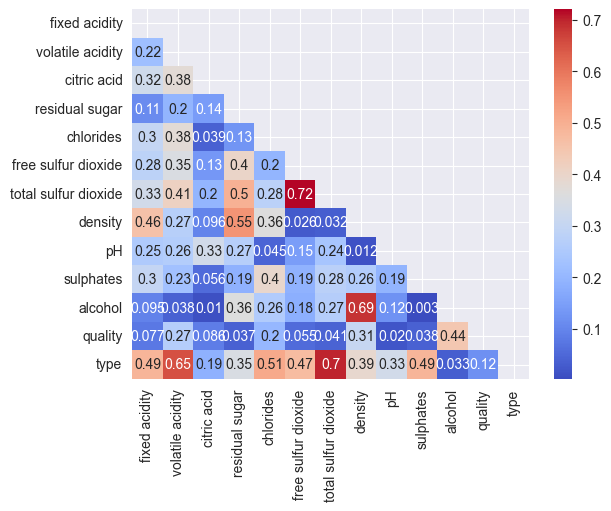

In [205]:
df = get_dataset()

y = df.pop("quality").values
X = df.values
tmp = []
for i in y:
    t = [0] * 10
    t[i] = 1
    tmp.append(t)
y = tmp

from torch.utils.data import TensorDataset, DataLoader

X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True
)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]

In [206]:

n_epochs = 1000
learning_rate = 0.0001
loss_fn = SoftmaxCrossEntropyLoss()
model = Model(
    layers=[
        Linear(input_size, 128, lr_rate=learning_rate),
        ReLU(),
        Linear(128, 256, lr_rate=learning_rate),
        ReLU(),
        Linear(256, 10, lr_rate=learning_rate)],
    loss=loss_fn
)

In [207]:
def evaluate(model, loader):
    model.Mode = Model.Mode.Eval
    correct = 0
    total = 0
    all_preds = []
    all_quality = []
    for features, quality in loader:
        features = features.detach().numpy()
        quality = quality.detach().numpy()

        preds = np.argmax(model(features), axis=1)
        quality = np.argmax(quality, axis=1)

        correct += (preds == quality).sum().item()
        total += quality.size
        all_preds.extend(preds)
        all_quality.extend(quality)

    accuracy = correct / total * 100
    return accuracy, np.array(all_quality), np.array(all_preds)

In [208]:


train_loss_history = []
test_accuracy_history = []
test_loss_history = []

for epoch in range(n_epochs):
    model.Mode = Model.Mode.Train
    epoch_loss = 0
    batch_count = 0
    for features, labels in train_loader:
        batch_count += 1
        features = features.detach().numpy()
        labels = labels.detach().numpy()

        predictions = model(features)

        loss = loss_fn(predictions, labels)
        epoch_loss += loss
        batch_count += 1
        model.backward(loss_fn.backward())

    avg_loss = epoch_loss / batch_count
    train_loss_history.append(avg_loss)
    test_accuracy, _, _ = evaluate(model, test_loader)
    test_accuracy_history.append(test_accuracy)

    if epoch % 10 == 0 and epoch != 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 10/1000, Loss: 0.5794, Test Accuracy: 52.26%
Epoch 20/1000, Loss: 0.5489, Test Accuracy: 53.44%
Epoch 30/1000, Loss: 0.5354, Test Accuracy: 54.36%
Epoch 40/1000, Loss: 0.5271, Test Accuracy: 54.05%
Epoch 50/1000, Loss: 0.5208, Test Accuracy: 54.67%
Epoch 60/1000, Loss: 0.5159, Test Accuracy: 54.05%
Epoch 70/1000, Loss: 0.5117, Test Accuracy: 54.36%
Epoch 80/1000, Loss: 0.5079, Test Accuracy: 54.46%
Epoch 90/1000, Loss: 0.5047, Test Accuracy: 54.21%
Epoch 100/1000, Loss: 0.5017, Test Accuracy: 54.05%
Epoch 110/1000, Loss: 0.4989, Test Accuracy: 54.05%
Epoch 120/1000, Loss: 0.4965, Test Accuracy: 54.00%
Epoch 130/1000, Loss: 0.4940, Test Accuracy: 54.46%
Epoch 140/1000, Loss: 0.4919, Test Accuracy: 54.51%
Epoch 150/1000, Loss: 0.4897, Test Accuracy: 54.36%
Epoch 160/1000, Loss: 0.4874, Test Accuracy: 54.36%
Epoch 170/1000, Loss: 0.4856, Test Accuracy: 54.92%
Epoch 180/1000, Loss: 0.4835, Test Accuracy: 55.33%
Epoch 190/1000, Loss: 0.4817, Test Accuracy: 54.46%
Epoch 200/1000, Loss:

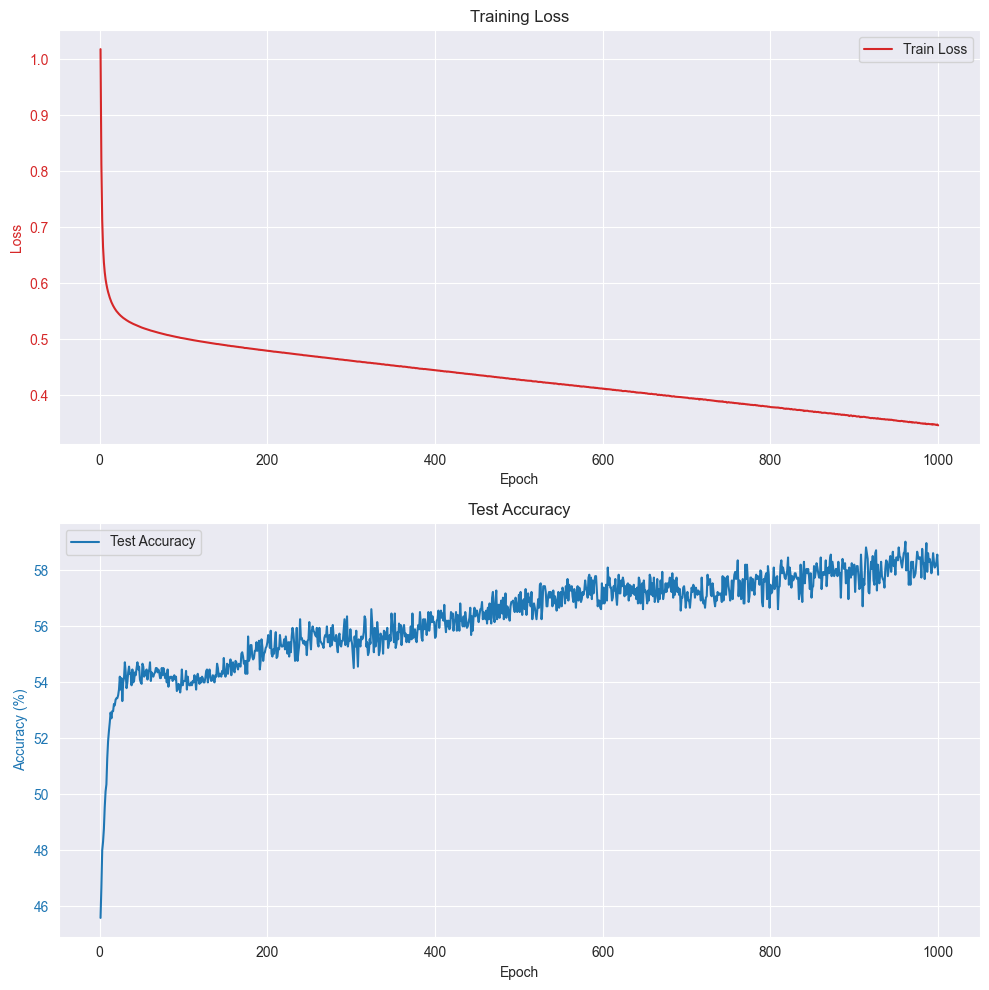

In [209]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, n_epochs + 1), train_loss_history, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
ax1.set_title("Training Loss")

color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, n_epochs + 1), test_accuracy_history, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title("Test Accuracy")

plt.tight_layout()
plt.show()

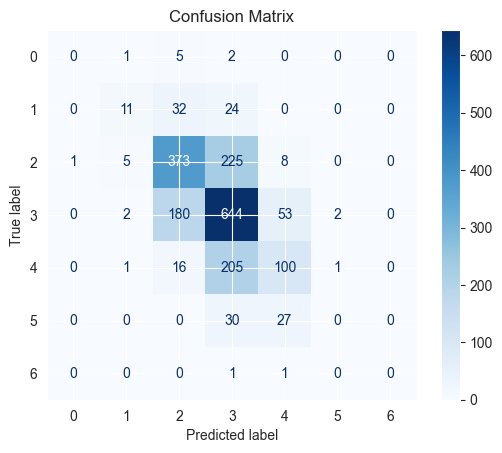

In [210]:
plt.show()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, y_true, y_pred = evaluate(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [217]:
import pandas as pd

x = X_test
y_expected = y_test
y_pred = model(x.detach().numpy())
res = {
    "prediction": [],
    "expected": [],
}
for i in range(len(y_pred)):
    res['prediction'].append(np.argmax(y_pred[i]))
    res['expected'].append(y_expected[i].detach().numpy().argmax())

df = pd.DataFrame(
    res
)

df

,prediction,expected
0,5,5
1,5,6
2,6,6
3,6,7
4,6,5
...,...,...
1945,6,3
1946,6,7
1947,5,6
1948,7,7


In [218]:
from sklearn.metrics import classification_report

report = classification_report(res["expected"], res["prediction"], zero_division=0)
print(report)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.55      0.16      0.25        67
           5       0.62      0.61      0.61       612
           6       0.57      0.73      0.64       881
           7       0.53      0.31      0.39       323
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00         2

    accuracy                           0.58      1950
   macro avg       0.32      0.26      0.27      1950
weighted avg       0.56      0.58      0.55      1950

